In [2]:
import time
import json
import os 
import logging

import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

In [161]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", font="Arial")
colors = sns.color_palette("Paired", n_colors=12).as_hex()

# https://github.com/ldeecke/gmm-torch.git
def plot(data, y):
    n = y.shape[0]

    fig, ax = plt.subplots(1, 1, figsize=(1.61803398875*4, 4))
    ax.set_facecolor("#bbbbbb")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")

    # plot the locations of all data points ..
    for i, point in enumerate(data.data):
        if i <= n//2:
            # .. separating them by ground truth ..
            ax.scatter(*point, color="#000000", alpha=.75, zorder=n+i)
        else:
            ax.scatter(*point, color="#ffffff", alpha=.75, zorder=n+i)

        if y[i] == 0:
            # .. as well as their predicted class
            ax.scatter(*point, zorder=i, color="#dbe9ff", alpha=.6, edgecolors=colors[1])
        else:
            ax.scatter(*point, zorder=i, color="#ffdbdb", alpha=.6, edgecolors=colors[5])

    handles = [plt.Line2D([0], [0], color="w", lw=4, label="Ground Truth 1"),
        plt.Line2D([0], [0], color="black", lw=4, label="Ground Truth 2"),
        plt.Line2D([0], [0], color=colors[1], lw=4, label="Predicted 1"),
        plt.Line2D([0], [0], color=colors[5], lw=4, label="Predicted 2")]

    legend = ax.legend(loc="best", handles=handles)

    plt.tight_layout()
    plt.savefig("example.pdf")

In [105]:
def matmul_per_components(n_components, mat_a, mat_b):
    """
    mat_a: x_mu_T    (n, k, 1, d)
    mat_b: precision (1, k, d, d)
    """
    res = torch.zeros(mat_a.shape)
    for i in range(n_components):
        mat_a_i = mat_a[:, i, :, :].squeeze(-2) #(n, d)
        mat_b_i = mat_b[:, i, :, :].squeeze()   #(d, d)
        res[:, i, :, :] = mat_a_i.mm(mat_b_i).unsqueeze(1) # (x-mu) * (1/var)
    return res

def calculate_matmul(mat_a, mat_b):
    """
    input: 
        mat_a: x_mu_T_precision (n, k, 1, d)
        mat_b: x_mu             (n, k, d, 1)
        
    return:                     (n, k, 1, 1)
    """
    return torch.sum(mat_a.squeeze(-2) * mat_b.squeeze(-1), dim = 2, keepdim = True)

In [145]:
import torch
import numpy as np

from math import pi
from scipy.special import logsumexp


class GaussianMixture(torch.nn.Module):
    """
    Input tensors:    (n,d) n= number of samples, d = number of features
    model parameters: (mu, sigma) (k,d)
    """
    
    def __init__(self, n_components, n_features, covariance_type="full", eps=1.e-6, init_params="kmeans", mu_init=None, var_init=None):
        """
        x:              torch.Tensor (n, 1, d)
        mu:             torch.Tensor (1, k, d)
        var:            torch.Tensor (1, k, d, d)
        pi:             torch.Tensor (1, k, 1)
        log_likelihood: float
        n_components:   int
        n_features:     int
        """
        super(GaussianMixture, self).__init__()
        self.n_components = n_components
        self.n_features = n_features
        self.covariance_type = covariance_type
        self.log_likelihood = -np.inf
        self.eps = eps
        
        self.mu_init = mu_init
    
    def fit(self, x, delta = 1e-3, n_iter = 100):
        self.initialize_parameters()
        
        x = self.check_size(x)
        #if self.mu_init is None :
        #   self.mu = self.get_kmeans_mu(x, n_centers = self.n_components) #gmm에서 mu의 초기화로 kmeans를 많이 사용함.
        
        i = 0
        j = np.inf
        
        while (i <= n_iter) and (j >= delta):
            log_likelihood_old = self.log_likelihood
            mu_old = self.mu
            var_old = self.var
            
            #EM step (x의 logprob구하기 -> parameter구하기)
            log_likelihood_old_for_check, log_resp = self._e_step(x) #old (mu, var, pi)로 x -> component에 할당하기 (responsibility 구하기)
            self._m_step(x, log_resp) #새로 구한 resp로 new (mu, var, pi)구하기
            self.log_likelihood = self.__score(x) #new_loglikelihood구하기
            
            i += 1
            j = self.log_likelihood = log_likelihood_old
            
            if j <= delta:
                #업데이트 된 값을 다시 원래대로 복원..
                self.mu = mu_old
                self.var = var_old
                
    def predict(self, x, probs = False):
        x = self.check_size(x)
        
        weighted_log_prob = self._estimate_log_prob(x) + torch.log(self.pi)
        return torch.squeeze(torch.max(weighted_log_prob, 1)[1].type(torch.LongTensor))
        
    def initialize_parameters(self):
        if self.mu_init == None:
            self.mu = torch.nn.Parameter(torch.randn(1, self.n_components, self.n_features), requires_grad = False)
        
        if self.covariance_type == "full":
            #"full" means the components may independently adopt any position and shape
            # (1, k, d, d)
            self.var = torch.nn.Parameter(
                torch.eye(self.n_features).reshape(1, 1, self.n_features, self.n_features).repeat(1, self.n_components, 1, 1),
                requires_grad=False
            )
        if self.covariance_type == "diag":
            # (1,k,d)
            self.var = torch.nn.Parameter(torch.ones(1, self.n_components, self.n_features), requires_grad=False)
        if self.covariance_type == "tied":
            pass
        if self.covariance_type == "tied diag":
            pass
        if self.covariance_type == "spherical":
            pass
        
        self.pi = torch.nn.Parameter(torch.Tensor(1, self.n_components, 1), requires_grad=False).fill_(1. / self.n_components)
    
    def __score(self, x, as_average=False):
        """
        Computes the log-likelihood of the data under the model.
        """
        weighted_log_prob = self._estimate_log_prob(x) + torch.log(self.pi)
        per_sample_score = torch.logsumexp(weighted_log_prob, dim=1)

        if as_average:
            return per_sample_score.mean()
        else:
            return torch.squeeze(per_sample_score)
        
    def _e_step(self, x):
        """
        args:
            x:              torch.Tensor (n, d) or (n, 1, d)
            
        returns:
            log_prob_norm:  torch.Tensor (1)
            log_resp:       torch.Tensor (n, k, 1)
        """
        x = self.check_size(x)

        ## loglikelihood = sum_x(ln(sum_z(pi * N(x|mu, var))) = sum_x(sum_z(ln(pi * N(x|mu,var))))
        # ln(pi * N(x|mu,var) -> ln(pi) + ln(x|mu,var)
        weighted_log_prob = self._estimate_log_prob(x) + torch.log(self.pi) #(n, k, 1)
        # sum_z(ln(pi*N(x|m,v))) -> log(sum(exp(log_prob))) -> log(sum(pi*x))
        log_prob_norm = torch.logsumexp(weighted_log_prob, dim = 1, keepdim = True) 
        
        # responsibility = posterior = p(theta | x)
        log_resp = weighted_log_prob - log_prob_norm
        return torch.mean(log_prob_norm), log_resp # (1), (n, k, 1)
    
    def _m_step(self, x, log_resp):
        """compute new parameters(mu, var, pi) of gaussian mixture model
        
        args:
            x.size:        (n, 1, d)
            log_resp.size: (1, k, 1)
            
        returns:
            pi:  (1, k, 1)
            mu:  (1, k, d)
            var: (1, k, d)
        """
        x = self.check_size(x)
        resp = torch.exp(log_resp)
        pi = torch.sum(resp, dim= 0, keepdim = True) + self.eps
        
        # mu.size = (n, k, 1)
        # --resp * x 계산을 위해서 x.size가 (n,d)가 아닌 (n,1,d)인지 확인해야함!
        mu = torch.sum(resp * x, dim = 0, keepdim = True) / pi
        eps = (torch.eye(self.n_features) * self.eps)
        var = torch.sum((x-mu).unsqueeze(-1).matmul((x-mu).unsqueeze(-2)) 
                        * resp.unsqueeze(-1), dim=0, keepdim=True) 
                / torch.sum(resp, dim=0, keepdim=True).unsqueeze(-1) 
                + eps
        pi = pi / x.shape[0]
        
        # update parameters
        # .data 사용해야하는 이유 : TypeError: cannot assign 'torch.FloatTensor' as parameter 'pi' (torch.nn.Parameter or None expected)
        self.pi.data = pi
        self.mu.data = mu
        self.var.data = var

    def _estimate_log_prob(self, x):
        """
        Returns a tensor with dimensions (n, k, 1), which indicates the log-likelihood that samples belong to the k-th Gaussian.
        
        args:
            x:            torch.Tensor (n, d) or (n, 1, d)
        returns:
            log_prob: torch.Tensor (n, k, 1)
        """
        x = self.check_size(x)
        mu = self.mu
        var = self.var
        precision = torch.inverse(var)
        d = x.shape[-1]
        print('precision size:',precision.size())
        
        log_2pi = d * np.log(2. * pi)
        
        # log_det를 구하는 이유는? log(var^2)대신에
        log_det = self._calculate_log_det(precision)
        
        ##(sum(x-mu)^2 / 2 * var) 의 과정이 좀 다르다 ..!
        x_mu_T = (x - mu).unsqueeze(-2) #(n, k, 1, d)
        x_mu = (x - mu).unsqueeze(-1)   #(n, k, d, 1)
        
        # 각 컴포넌트에 대해서 (x-mu) * (1/var) 계산 
        x_mu_T_precision = matmul_per_components(self.n_components, x_mu_T, precision)
        
        # (x_mu) * (1 / var) * x_mu
        # Q : matmul 대신 calculate_matmul(mat_a, mat_b)을 사용하려는 이유가 뭐였을까?
        # A : result.size() : torch.matmul -> torch.Size([1, 2, 3, 3]) calculate_matmul -> torch.Size([300, 2, 1])
        x_mu_T_precision_x_mu = calculate_matmul(x_mu_T_precision, x_mu) 
        return -.5 * (log_2pi - log_det + x_mu_T_precision_x_mu)
        
    def _calculate_log_det(self, var):
        """Calculate log determinant in log space, to prevent overflow errors.
        
        args:
            var:            torch.Tensor (1, k, d, d)
        """
        log_det = torch.empty(size=(self.n_components,)).to(var.device)
        
        for k in range(self.n_components):
            log_det[k] = 2 * torch.log(torch.diagonal(torch.linalg.cholesky(var[0,k]))).sum()

        return log_det.unsqueeze(-1)
    
    def check_size(self, x):
        if len(x.size()) == 2:
            # (n, d) --> (n, 1, d)
            x = x.unsqueeze(1)
        return x

In [164]:
from math import sqrt

n, d = 300, 2

# generate some data points ..
data = torch.Tensor(n, d).normal_()
# .. and shift them around to non-standard Gaussians
data[:n//2] -= 1
data[:n//2] *= sqrt(3)
data[n//2:] += 1
data[n//2:] *= sqrt(2)

precision size: torch.Size([1, 2, 2, 2])
torch.Size([300, 2, 1])
torch.Size([300, 1, 2])
precision size: torch.Size([1, 2, 2, 2])
precision size: torch.Size([1, 2, 2, 2])


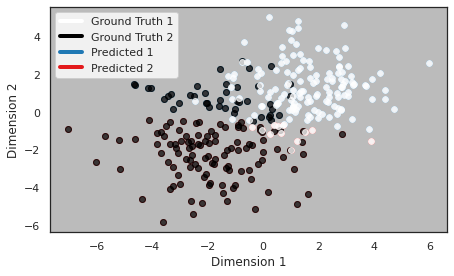

In [165]:
# Next, the Gaussian mixture is instantiated and ..
n_components = 2
model = GaussianMixture(n_components, d)
model.fit(data)

# .. used to predict the data points as they where shifted
y = model.predict(data)

plot(data,y)

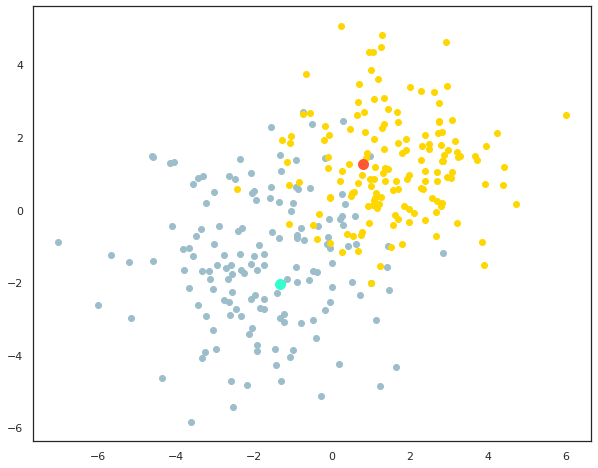

In [186]:
plt.figure(figsize=(10,8))
mean = model.mu.numpy()

plt.scatter(data[:n//2, 0], data[:n//2, 1], c = '#9cbeca' )
plt.scatter(data[n//2:, 0], data[n//2:, 1], c = '#ffd700')
plt.scatter(mean[0,0,0], mean[0,0,1], c='#FF5733', s=100)
plt.scatter(mean[0,1,0], mean[0,1,1], c='#33FFCE', s=100)